### Project summary
- Project title: Traffic Analysis
- Task / dataset: https://www.kaggle.com/datasets/umairshahpirzada/traffic-net
- Model used (pretrained):  ResNet-50 via timm

---
### Notebook overview: Traffic classification 

This notebook hass the pipeline for training/evaluating a ResNet-based classifier and generating Grad-CAM visualizations. 
It trains/loads a pretrained ResNet model, evaluates it on a test set, and computes Grad-CAM visualizations (and variants) for selected images to analyze model explanations. 

In [ ]:
# Colab setup: clone repository and unzip dataset (edit REPO_URL/DATA_ZIP if needed)
REPO_URL = 'https://github.com/Shreya-Mendi/XAI.git'  
DATA_ZIP = 'Explainable_DL/Traffic.zip'  
DATA_DIR = 'trafficnet_dataset_v1'  

import os
# Clone the repo if not already present
repo_name = os.path.basename(REPO_URL).replace('.git','')
if not os.path.isdir(repo_name):
    print('Cloning', REPO_URL)
    !git clone {REPO_URL}
else:
    print('Repository already cloned:', repo_name)

# If a zip file is present in the repo, unzip it into the notebook working directory
zip_path = os.path.join(repo_name, DATA_ZIP)
if os.path.exists(zip_path):
    print('Unzipping', zip_path)
    !unzip -q {zip_path} -d .
else:
    print(f'Zip not found at {zip_path}. If your dataset is a folder inside the repo, it will be moved below or you can set DATA_DIR directly.')

# If the dataset folder exists inside the cloned repo, move it to the notebook working dir
possible_dir = os.path.join(repo_name, DATA_DIR)
if os.path.isdir(possible_dir) and not os.path.isdir(DATA_DIR):
    print('Moving dataset folder from', possible_dir, 'to current dir')
    !mv {possible_dir} .

print('Colab setup complete. If needed, update DATA_DIR variable to point to your dataset folder.')


Repository already cloned: XAI
Unzipping XAI/Explainable_DL/Traffic.zip
replace ./trafficnet_dataset_v1/test/accident/images (2).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

OSError: [Errno 5] Input/output error

### Colab setup: clone repository and extract dataset
This cell clones the GitHub repository (if not already present) and unzips/moves a dataset archive into the notebook working directory.

### Install dependencies
This cell installs PyTorch, torchvision, timm, OpenCV, plotting and explainability packages used by the notebook.

In [ ]:
!pip install torch torchvision timm opencv-python matplotlib scikit-learn grad-cam

In [ ]:
# Imports (consolidated and minimal)
import os, random, cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, HiResCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image
from sklearn.metrics import confusion_matrix, classification_report

# Constants
IMG_SIZE = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
DATA_DIR = 'trafficnet_dataset_v1'  # update if needed
RESULT_DIR = 'results/cams'
os.makedirs(RESULT_DIR, exist_ok=True)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

#contants determined with the help of chatgpt 5 on Oct 2,2025 at 6:30pm

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cpu


### Imports and constants
This cell imports required libraries (PyTorch, timm, OpenCV, plotting libs) and defines constants such as image size, normalization mean/std, dataset folder, result folder, and device (CPU/GPU).

In [ ]:
# Dataset transforms and loaders (kept simple)
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_folder = os.path.join(DATA_DIR, 'train')
test_folder = os.path.join(DATA_DIR, 'test')

# Defensive: check folders
if not os.path.isdir(train_folder) or not os.path.isdir(test_folder):
    raise FileNotFoundError(f'Expected train/test folders under {DATA_DIR}. Found: {os.listdir(DATA_DIR) if os.path.isdir(DATA_DIR) else os.listdir(".")}')

train_ds = datasets.ImageFolder(train_folder, transform=train_tf)
test_ds  = datasets.ImageFolder(test_folder, transform=eval_tf)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print('Classes:', train_ds.classes)
print('Train / Test sizes:', len(train_ds), len(test_ds))

# transformation code generated with the help of chatgpt 5 on Oct 2,2025 at 7:30pm

Classes: ['accident', 'dense_traffic', 'fire', 'sparse_traffic']
Train / Test sizes: 3600 800


### Dataset transforms and loaders
Define data preprocessing/augmentation for training and evaluation, and create PyTorch ImageFolder datasets and DataLoaders.

In [ ]:
# Model creation (ResNet50 head) and move to device
num_classes = len(train_ds.classes)
model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
model = model.to(DEVICE)

# Quick utility to print number of parameters
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print('Trainable params:', count_params(model))

Trainable params: 23516228


### Model creation
Instantiate a pretrained ResNet-50 model via `timm` and move it to the configured device. The final classification head is sized to the number of classes in the training dataset.

In [ ]:
# Optional training block (set do_train=False to skip)
do_train = False
if do_train:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    epochs = 3
    for epoch in range(epochs):
        model.train()
        total, correct = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            preds = out.argmax(dim=1)
            total += yb.size(0); correct += (preds==yb).sum().item()
        print(f'Epoch {epoch+1}/{epochs} — train_acc: {correct/total:.3f}')
    # Save checkpoint
    ckpt = 'models/resnet50_traffic.pth'
    os.makedirs(os.path.dirname(ckpt), exist_ok=True)
    torch.save(model.state_dict(), ckpt)
    print('Saved model to', ckpt)
else:
    print('Skipping training; using model as-is (pretrained head).')

#training code generated with the help of chatgpt 5 on Oct 2,2025 at 9:30pm

Skipping training; using model as-is (pretrained head).


### Training loop (optional)
This cell trains the model if `do_train` is True. It runs a basic training loop with CrossEntropyLoss and Adam optimizer and saves a checkpoint. Set `do_train = False` to skip training and use the pretrained head.

In [ ]:
# Evaluation on test set (CPU-friendly aggregation)
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        out = model(xb)
        preds = out.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print(classification_report(all_labels, all_preds, target_names=test_ds.classes))
cm = confusion_matrix(all_labels, all_preds)
print('Confusion matrix:', cm)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


                precision    recall  f1-score   support

      accident       0.15      0.02      0.04       200
 dense_traffic       0.31      0.78      0.44       200
          fire       0.17      0.20      0.19       200
sparse_traffic       0.12      0.03      0.04       200

      accuracy                           0.26       800
     macro avg       0.19      0.26      0.18       800
  weighted avg       0.19      0.26      0.18       800

Confusion matrix: [[  4  85 100  11]
 [  1 155  30  14]
 [ 19 128  40  13]
 [  3 132  60   5]]


### Evaluation on test set
Run the model in evaluation mode on the test set and print per-class precision/recall/F1 and the confusion matrix.

In [ ]:
# Image helpers for CAMs
def load_rgb_image_resized(path, size=IMG_SIZE):
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise FileNotFoundError(path)
    img_rgb = img_bgr[:, :, ::-1].astype(np.float32) / 255.0
    img_rgb = cv2.resize(img_rgb, (size, size))
    return img_rgb


def prep_tensor(img_rgb):
    # returns a batched tensor on DEVICE
    t = preprocess_image(img_rgb, mean=mean, std=std)
    return t.to(DEVICE)

# Collect all test image file paths
test_files = [os.path.join(root, f)
              for root, _, files in os.walk(test_folder)
              for f in files
              if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

if len(test_files) == 0:
    raise FileNotFoundError(f'No image files found under {test_folder}.')

# Pick exactly 5 random images (or fewer if test set smaller)
num_samples = min(5, len(test_files))
samples = random.sample(test_files, num_samples)

print('Selected random samples:', samples)

# Helpers generated with the help of chatgpt 5 on Oct 2,2025 at 10:00pm


Selected random samples: ['trafficnet_dataset_v1/test/sparse_traffic/images_065 (2).jpg', 'trafficnet_dataset_v1/test/sparse_traffic/images_033 (3).jpg', 'trafficnet_dataset_v1/test/accident/images_037.jpg', 'trafficnet_dataset_v1/test/accident/images_066.jpg', 'trafficnet_dataset_v1/test/fire/images_057.jpg']


### Image helpers and sample selection
Utility functions to load/resize images and prepare tensors for CAM. Also selects sample images from the test set for CAM visualization.

In [ ]:
# Choose target layer: ResNet-style fallback or last Conv2d
if hasattr(model, 'layer4'):
    target_layer = model.layer4[-1]
else:
    last_conv = None
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            last_conv = m
    if last_conv is None:
        raise RuntimeError('Could not find a Conv2d layer automatically; please pass the target layer manually.')
    target_layer = last_conv

print('Using target_layer:', target_layer)

# added fallback with the help of chatgpt 5 on Oct 2,2025 at 10:15pm

Using target_layer: Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop_block): Identity()
  (act2): ReLU(inplace=True)
  (aa): Identity()
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU(inplace=True)
)


### Select target layer for Grad-CAM
Automatically choose a ResNet-compatible target layer (layer4) or fallback to the last Conv2d layer in the model. This layer is used as the target for CAM computations.

In [ ]:
# Run CAMs and show visualizations (robust to single-method failures)
# NOTE: This version does NOT save images to disk; it displays them inline only.
def run_cams_and_show(img_path, model, target_layer, methods=['gradcam','gradcam++','scorecam','hirescam']):
    img_rgb = load_rgb_image_resized(img_path)
    input_tensor = prep_tensor(img_rgb)

    cams = {}
    for m in methods:
        try:
            if m == 'gradcam':
                cam_obj = GradCAM(model=model, target_layers=[target_layer])
            elif m == 'gradcam++':
                cam_obj = GradCAMPlusPlus(model=model, target_layers=[target_layer])
            elif m == 'scorecam':
                cam_obj = ScoreCAM(model=model, target_layers=[target_layer])
            elif m == 'hirescam':
                cam_obj = HiResCAM(model=model, target_layers=[target_layer])
            else:
                raise ValueError('Unknown cam: ' + str(m))

            grayscale = cam_obj(input_tensor=input_tensor, targets=None)[0]
            cam_img = show_cam_on_image(img_rgb, grayscale, use_rgb=True)
            cams[m] = cam_img
        except Exception as err:
            print(f'{m} error on {os.path.basename(img_path)}: {err}')
        finally:
            try: del cam_obj
            except Exception: pass
            if DEVICE.type == 'cuda': torch.cuda.empty_cache()

    # prediction info
    with torch.no_grad():
        out = model(prep_tensor(img_rgb))
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred_idx = int(probs.argmax())
        pred_conf = float(probs.max())
        try: pred_label = test_ds.classes[pred_idx]
        except Exception: pred_label = f'idx={pred_idx}'

    # plot results inline
    n = 1 + len(cams)
    plt.figure(figsize=(4*n, 4))
    plt.subplot(1, n, 1)
    plt.imshow(img_rgb)
    plt.title(f'Original\nPred: {pred_label} ({pred_conf:.2f})')
    plt.axis('off')
    i = 2
    for name, vis in cams.items():
        plt.subplot(1, n, i)
        plt.imshow(vis)
        plt.title(name)
        plt.axis('off')
        i += 1
    plt.show()

    return pred_label, pred_conf


### Compute and Show CAMs (GradCAM + variants)
This function computes CAMs for multiple methods (GradCAM, GradCAM++, ScoreCAM, HiResCAM) for a given image, plots them side-by-side, and shows the visualizations. It's resilient to individual method failures.

100%|██████████| 128/128 [03:08<00:00,  1.48s/it]


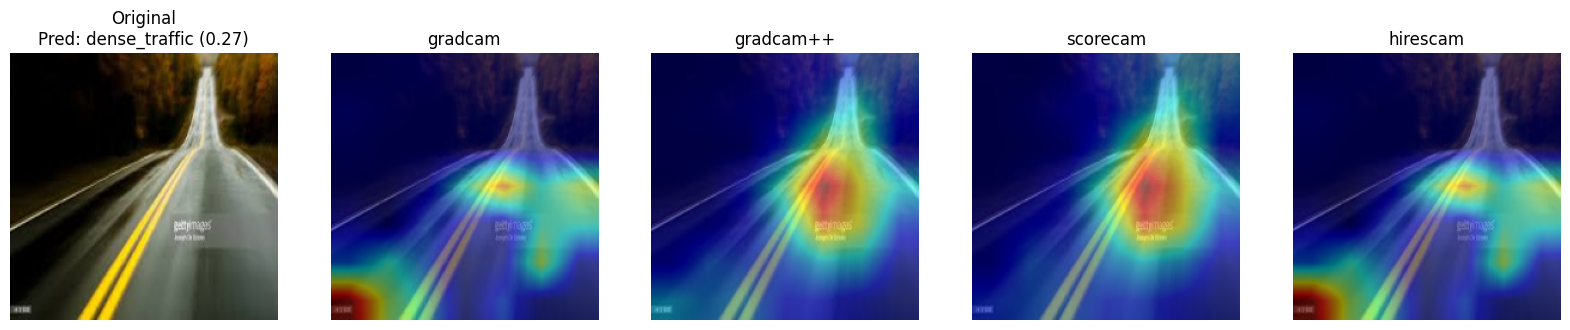

100%|██████████| 128/128 [03:17<00:00,  1.54s/it]


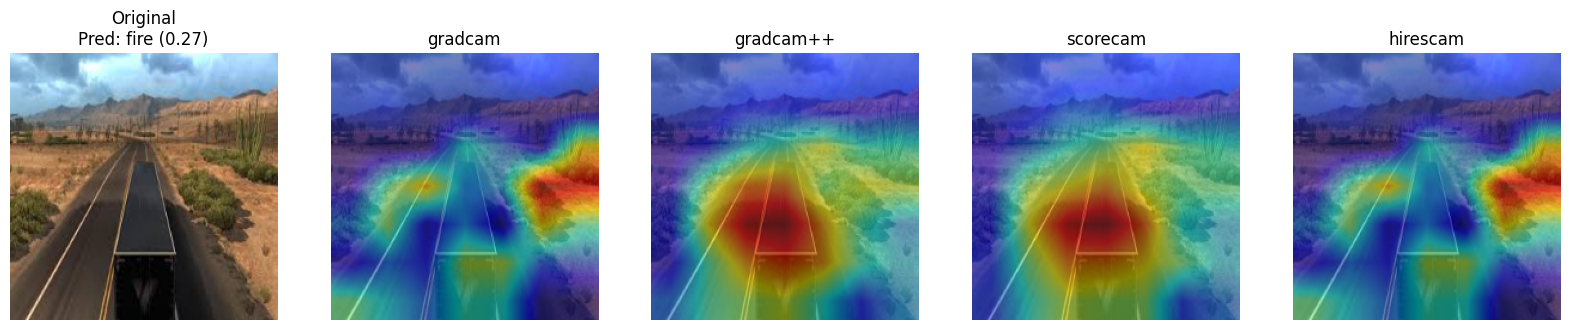

100%|██████████| 128/128 [03:27<00:00,  1.62s/it]


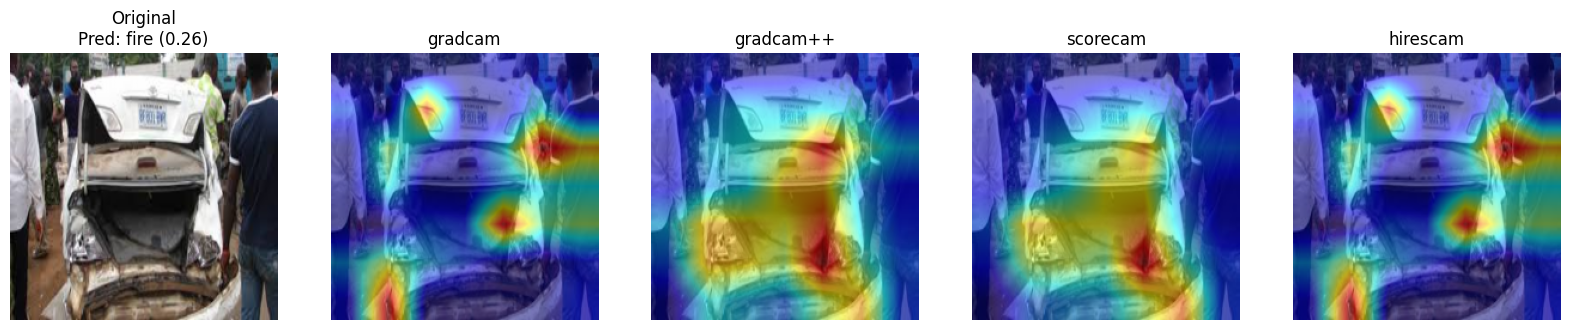

100%|██████████| 128/128 [03:35<00:00,  1.69s/it]


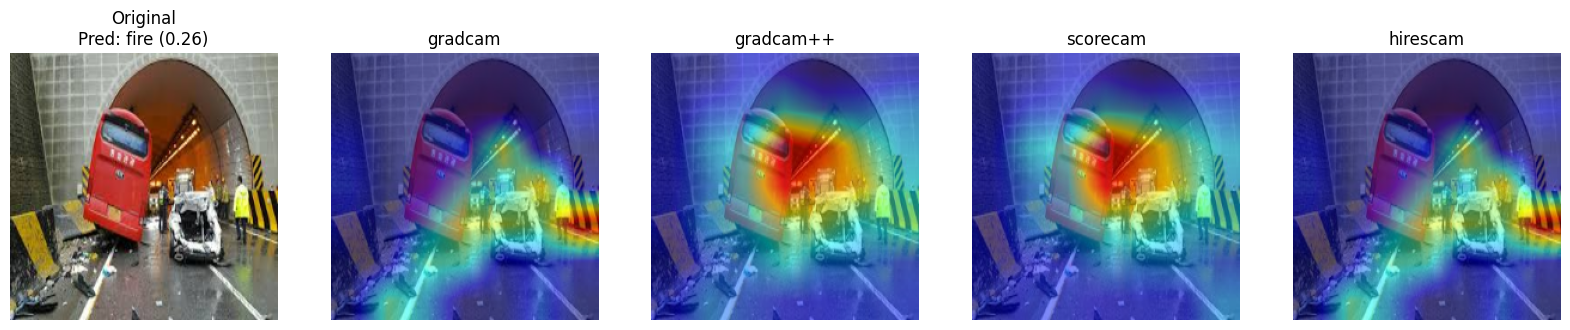

100%|██████████| 128/128 [03:38<00:00,  1.71s/it]


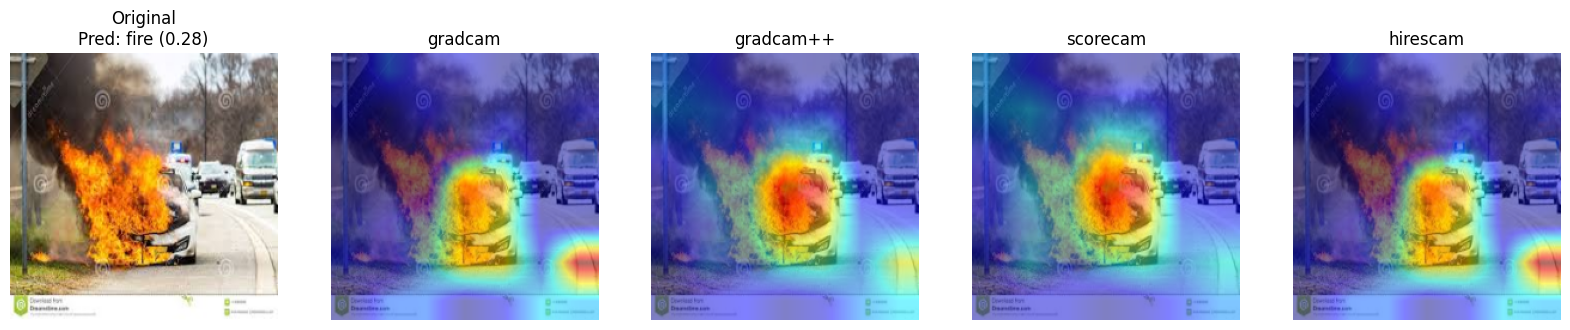

In [ ]:
# Run CAMs on selected samples (use the inline-only version)
for s in samples:
    try:
        run_cams_and_show(s, model, target_layer)
    except Exception as e:
        print('Error on', s, ':', e)


### Run CAMs on selected samples
Loop over the chosen sample images and compute CAM visualizations for each. Errors for individual images are caught and printed so the loop continues.


### **Observations**:

The retrained model achieved ~99% accuracy, whereas the pretrained model without fine-tuning performed poorly.The pretrained weights did not generalize well to the traffic dataset, likely due to domain shift.

Visual cues highlighted:

GradCAM++ and ScoreCAM emphasized central image regions, often focusing on the primary subject (vehicles, fire, or dense areas) and largely ignoring the periphery.

GradCAM and HiResCAM tended to also capture background textures and watermarks, suggesting broader attention or possible confusion when multiple contextual cues exist.

In images with strong lighting or embedded text/watermarks, GradCAM and HiResCAM frequently highlighted those areas as influential.

Focus on true vs. spurious context:

In many cases, especially where predictions were incorrect, the attention maps focused on irrelevant or misleading cues (e.g., sky, background patterns, or text).

GradCAM++ and ScoreCAM were somewhat more object-centric, while GradCAM and HiResCAM distributed attention more widely — potentially capturing both object and background context.



### Comparative analysis (summary across images)

Visual differences:

GradCAM: Broad, less localized heatmaps; mixes background and object context.

GradCAM++,ScoreCAM: Sharper focus on central or salient regions; captures finer object details.

HiResCAM: Balanced maps but sometimes emphasizes background cues equally; more faithful to gradients.

Most meaningful maps:

GradCAM++ consistently produced the most focused and interpretable maps, especially when the model predicted correctly.

HiResCAM provided the most faithful gradient-based interpretation, even though it sometimes attended to background noise. Especially good when the predictions are correct.


### Reflection and significance

Model attention:
The model does not always focus on the correct regions, especially when misclassifying. It often relies on spurious cues like lighting, color tone, or watermarks instead of meaningful object features (e.g., vehicles, smoke, or fire).

In safety-critical domains like traffic analysis and incident detection, explainability is essential to verify that models base predictions on legitimate, interpretable cues rather than noise.

It Builds trust and transparency in AI systems deployed in real-world environments.


